In [156]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import neo4j as neo
from sklearn import preprocessing
import numpy as np
import math

In [2]:
#Parsing instructions provided 
#https://snap.stanford.edu/data/web-Amazon.html

import gzip
import simplejson

def parse(filename):
  f = gzip.open(filename, 'rt', encoding = 'latin 1')
  entry = {}
  for l in f:
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

In [361]:
raw = []
for e in parse('Data/finefoods.txt.gz'):
  raw.append(e)

In [356]:
df = pd.DataFrame(raw)

In [7]:
df.head()

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [165]:
G = nx.convert_matrix.from_pandas_dataframe(df, source='review/userId', target='product/productId',edge_attr= 'review/score' ,create_using = nx.DiGraph())

In [317]:
nx.degree_centrality(G)

{'A3SGXH7AUHU8GW': 3.0273948964176835e-06,
 'B001E4KFG0': 3.0273948964176835e-06,
 'A1D87F6ZCVE5NK': 3.0273948964176835e-06,
 'B00813GRG4': 3.0273948964176835e-06,
 'ABXLMWJIXXAIN': 9.082184689253051e-06,
 'B000LQOCH0': 3.0273948964176835e-06,
 'A395BORC6FGVXV': 9.082184689253051e-06,
 'B000UA0QIQ': 3.0273948964176835e-06,
 'A1UQRSCLF8GW1T': 6.054789792835367e-06,
 'B006K2ZZ7K': 1.2109579585670734e-05,
 'ADT0SRK1MGOEU': 3.0273948964176835e-06,
 'A1SP2KVKFXXRU1': 6.054789792835367e-06,
 'A3JRGQVEQN31IQ': 3.0273948964176835e-06,
 'A1MZYO9TZK0BBI': 6.054789792835367e-06,
 'B000E7L2R4': 3.0273948964176835e-06,
 'A21BT40VZCCYT4': 1.2109579585670734e-05,
 'B00171APVA': 3.0273948964176835e-06,
 'A3HDKO7OW0QNK4': 1.2109579585670734e-05,
 'B0001PB9FE': 3.0273948964176835e-06,
 'A2725IB4YY9JEB': 3.6328738757012204e-05,
 'B0009XLVG0': 6.054789792835367e-06,
 'A327PCT23YH90': 6.054789792835367e-06,
 'A18ECVX2RJ7HUE': 6.054789792835367e-05,
 'B001GVISJM': 4.541092344626525e-05,
 'A2MUGFV2TDQ47K': 0

In [341]:
nx.diameter(G.to_undirected())

NetworkXError: Graph not connected: infinite path length

In [172]:
#network is not connect to apply certain calculations such as diameter()
#here we can see there are thousands of seperate networks within the data.
components = list(nx.connected_components(G.to_undirected()))
comp_count = len(components)
comp_count

22079

In [173]:
#Looking further, we see that the dataset in not very connected at all.
comp_lens = pd.DataFrame([len(c) for c in components])
comp_lens.median()

0    2.0
dtype: float64

In [340]:
comp_lens[comp_lens[0]>20].sort_values(0, ascending=False).head()

,0
2,269996
785,135
3681,46
1565,39
9233,34


In [322]:
#Here we select a decent sized connected component to evaluate
S = G.subgraph(components[785])

In [323]:
nx.info(S)

'Name: \nType: DiGraph\nNumber of nodes: 135\nNumber of edges: 136\nAverage in degree:   1.0074\nAverage out degree:   1.0074'

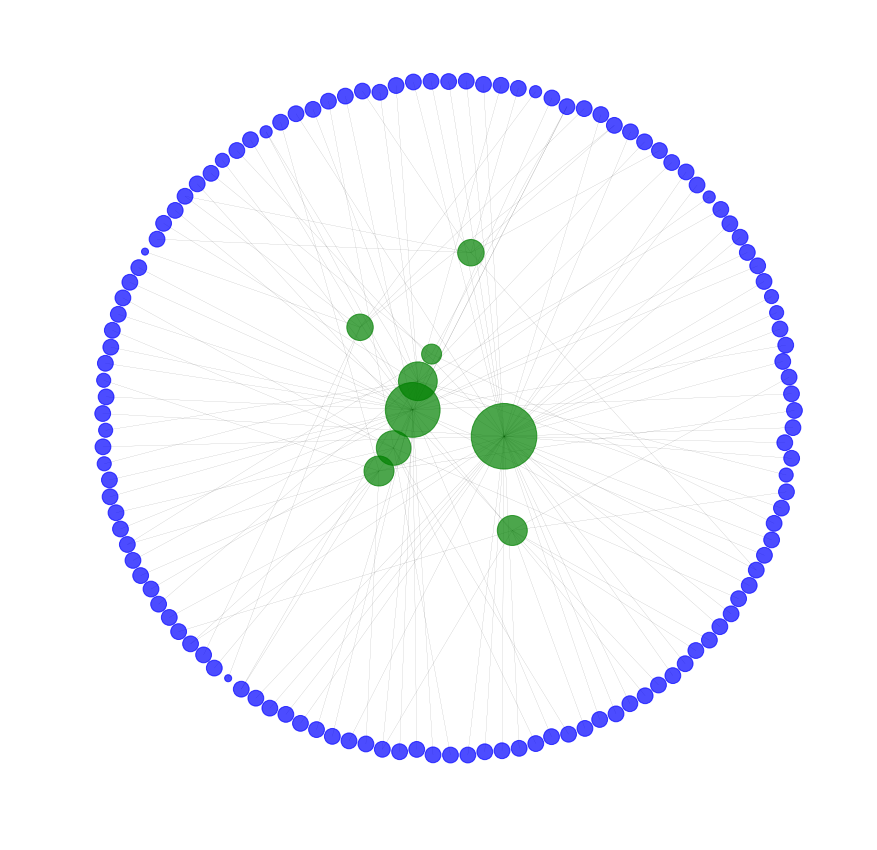

In [328]:
#Blue are the people, Green are the products
#Products are sized in proportion to their degree, people are sized per their average rating
S_col = ['blue' if n[0] == 'A' else 'green' for n in S.nodes()]
S_size = [sum(np.array([float(S[n][v]['review/score']) for n,v in S.edges(n)]))*50/np.array(S.degree(n)) if n[0] == 'A' else np.array(S.degree(n))*100 for n in S.degree()]
S_weights = np.array([float(S[u][v]['review/score']) for u,v in S.edges()])
S_weights_sd = math.sqrt(sum((S_weights - S_weights.mean())**2)/len(S_weights))
S_weights_norm = ((S_weights - S_weights.mean())/S_weights_sd)

fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(S,node_color=S_col,alpha = .7,width = .1, arrows=False , node_size = S_sizeb)
plt.show()

In [347]:
nx.diameter(S.to_undirected())

16

In [2]:
import os
os.chdir('/Users/mustafatelab/Desktop/CUNY SPS MSDS/DATA 620 Web Analytics/SPS_MSDS_SMR21_DATA620')

In [3]:
%pwd

'/Users/mustafatelab/Desktop/CUNY SPS MSDS/DATA 620 Web Analytics/SPS_MSDS_SMR21_DATA620'

NameError: name 'data' is not defined